# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
import re
import json

import seaborn as sns
from ProjectPackage.util import *
from ProjectPackage.DataProcessing import *

### Plotting ticker changes by sector

In [2]:
data_dict = load_data_model_2(
    n_months=6,
    pct_change=True,
    drop_corr_features=True,
    encoding_method=None,
    drop=False,
    year_range=(2008, 2019)
)

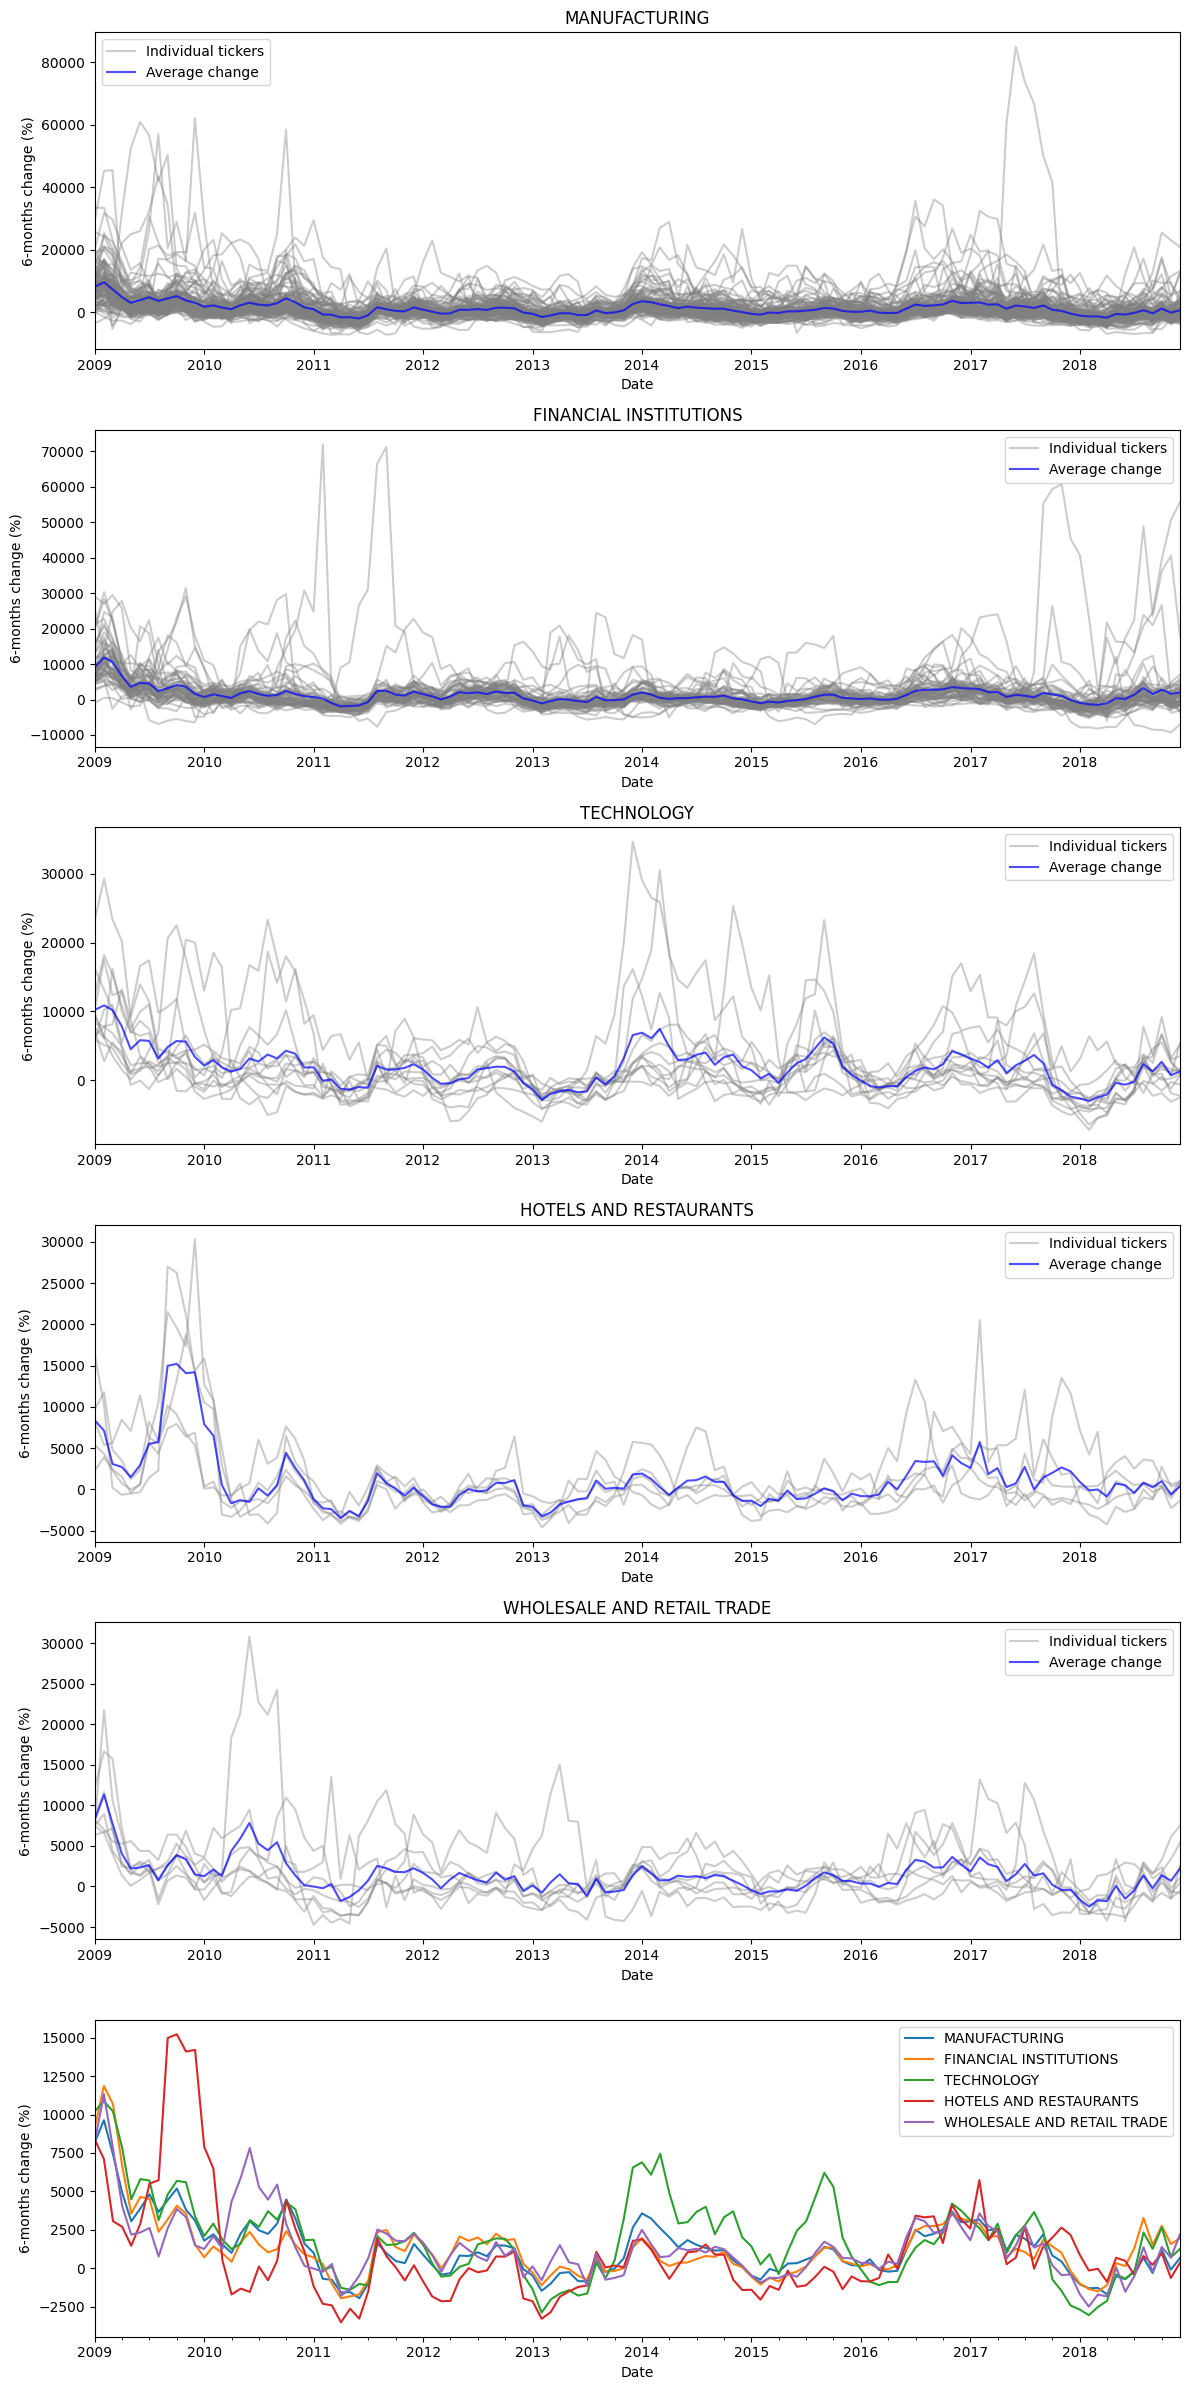

In [4]:
fig, axs = plt.subplots(len(data_dict)+1, 1, figsize=(12, 24), tight_layout=True)
axs = axs.flatten()

sector_change_dict = {}

for ax, (sector, data) in zip(axs, data_dict.items()):
    data = data['data']
    tickers = data['ticker'].unique()
    avg_arr = []
    data['marketcap'] *= 100
    
    for ticker in tickers:
        cond = data['ticker'] == ticker
        graph_data = data.loc[cond].sort_values(by='date')
        
        line = ax.plot('date', 'marketcap', data=graph_data, color='gray', alpha=0.4)
        ax.set_title(sector)
        ax.set_xlabel('Date')
        ax.set_ylabel('6-months change (%)')
        avg_arr.append(graph_data['marketcap'])
    
    avg_arr = np.array(avg_arr).mean(axis=0)
    sector_change_dict[sector] = avg_arr
    avg_line = ax.plot(graph_data['date'], avg_arr, color='blue', alpha=0.7)
    xmin, xmax = graph_data['date'].min(), graph_data['date'].max()
    ax.set_xlim(xmin, xmax)
    
    ax.legend(handles=[line[0], avg_line[0]], labels=['Individual tickers', 'Average change'])
    
ax = axs[-1]
avg_sector_data = pd.DataFrame(sector_change_dict)
avg_sector_data['date'] = graph_data.reset_index()['date']
avg_sector_data.plot(x='date', ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Date')
ax.set_ylabel('6-months change (%)')

plt.show()

In [5]:
avg_sector_data.iloc[:, :-1].corr()

,MANUFACTURING,FINANCIAL INSTITUTIONS,TECHNOLOGY,HOTELS AND RESTAURANTS,WHOLESALE AND RETAIL TRADE
MANUFACTURING,1.000000,0.892296,0.875423,0.685299,0.839818
FINANCIAL INSTITUTIONS,0.892296,1.000000,0.756427,0.559653,0.818556
TECHNOLOGY,0.875423,0.756427,1.000000,0.512642,0.699041
HOTELS AND RESTAURANTS,0.685299,0.559653,0.512642,1.000000,0.433188
WHOLESALE AND RETAIL TRADE,0.839818,0.818556,0.699041,0.433188,1.000000


------------

In [2]:
file_path = 'processed_data/feature_data.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

Keeping only one unemployment column:

In [3]:
df.columns

Index(['date', 'year', 'month', 'consumer_credits', 'consumer_price_index',
       'brent_oil_price', 'current_account_deficit', 'exports_usd',
       'imports_usd', 'export_unit_value_index_usd', 'gdp', 'gold_price_lon',
       'import_unit_value_index_usd', 'B', 'C', 'MIG_NRG_X_E', 'MIG_NDCOG',
       'MIG_ING', 'MIG_DCOG', 'MIG_CAG', 'interest_rates_personal',
       'money_supply', 'real_effective_echange_rates', 'retail_sales',
       'unemployment_30-34', 'ExchangeRate'],
      dtype='object')

In [4]:
df.head()

,date,year,month,consumer_credits,consumer_price_index,brent_oil_price,current_account_deficit,exports_usd,imports_usd,export_unit_value_index_usd,...,MIG_NDCOG,MIG_ING,MIG_DCOG,MIG_CAG,interest_rates_personal,money_supply,real_effective_echange_rates,retail_sales,unemployment_30-34,ExchangeRate
0,2009-01-01,2009,1,5.074031e+10,160.90,43.44,-330000000,7884493524,9281137649,95.1,...,60.4,49.3,49.2,31.8,22.8580,5.106825e+07,95.56,3.945135e+07,13.8,1.589052
1,2009-02-01,2009,2,4.863385e+10,160.35,43.32,-150000000,8435115834,9074663754,90.9,...,56.2,47.7,52.6,34.7,21.4725,5.232834e+07,93.34,1.199247e+07,14.9,1.652360
2,2009-03-01,2009,3,4.710121e+10,162.12,46.54,-1080000000,8155485081,10522038241,89.8,...,62.1,54.9,62.0,41.0,21.8000,5.154123e+07,91.39,2.469501e+07,14.5,1.704536
3,2009-04-01,2009,4,5.054903e+10,162.15,50.18,-1384000000,7561696283,10120319396,91.7,...,61.9,57.3,62.4,43.0,19.0125,5.481556e+07,96.10,2.976991e+07,13.0,1.604152
4,2009-05-01,2009,5,5.280357e+10,163.19,57.30,-1361000000,7346407528,10867698195,93.8,...,63.8,60.0,70.9,48.6,20.0160,5.771973e+07,97.79,9.979813e+06,11.4,1.551763


In [5]:
df.columns

Index(['date', 'year', 'month', 'consumer_credits', 'consumer_price_index',
       'brent_oil_price', 'current_account_deficit', 'exports_usd',
       'imports_usd', 'export_unit_value_index_usd', 'gdp', 'gold_price_lon',
       'import_unit_value_index_usd', 'B', 'C', 'MIG_NRG_X_E', 'MIG_NDCOG',
       'MIG_ING', 'MIG_DCOG', 'MIG_CAG', 'interest_rates_personal',
       'money_supply', 'real_effective_echange_rates', 'retail_sales',
       'unemployment_30-34', 'ExchangeRate'],
      dtype='object')

## Visualizing timeseries to see possible outliers

In [6]:
def plot_timeseries(df, col, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
        
    ax.plot('date', col, data=df, color='darkorange')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.grid()
    
    return ax

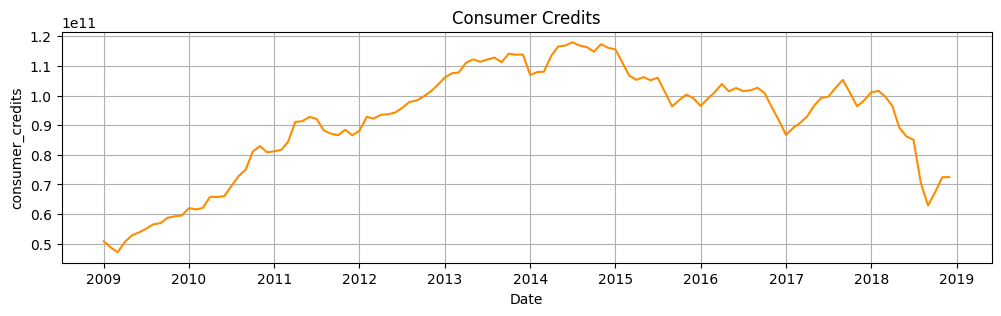

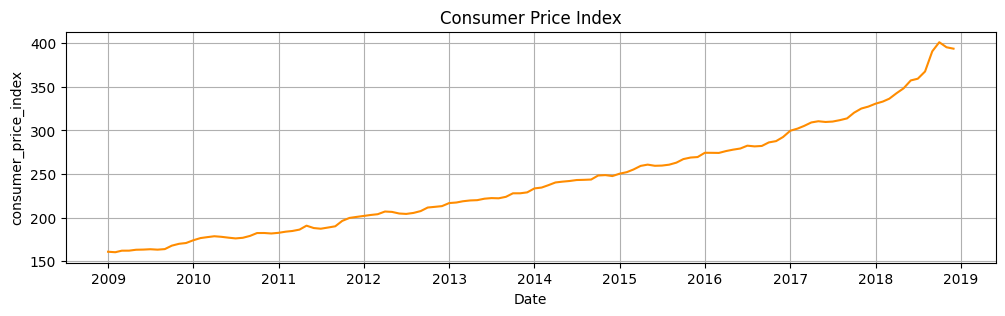

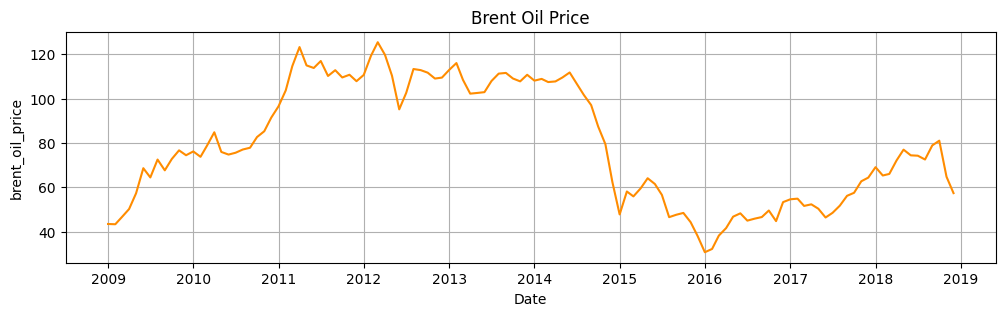

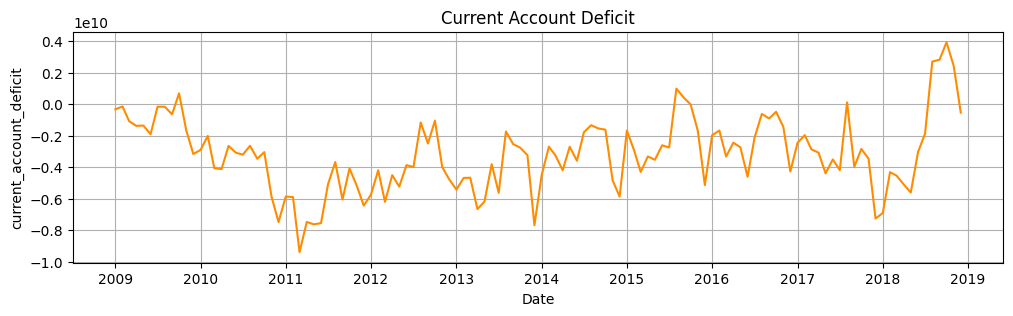

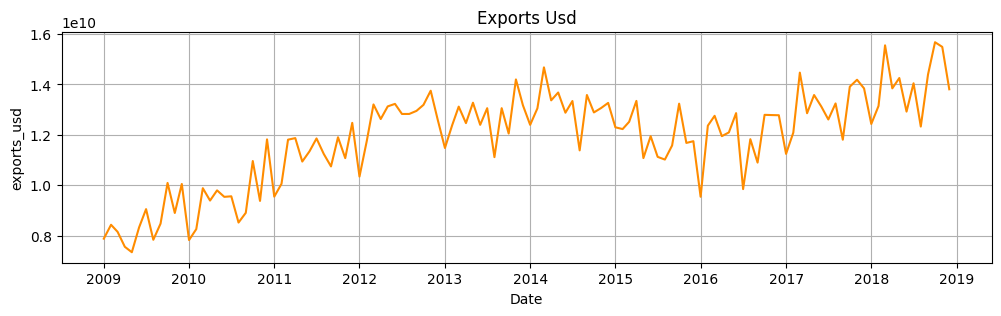

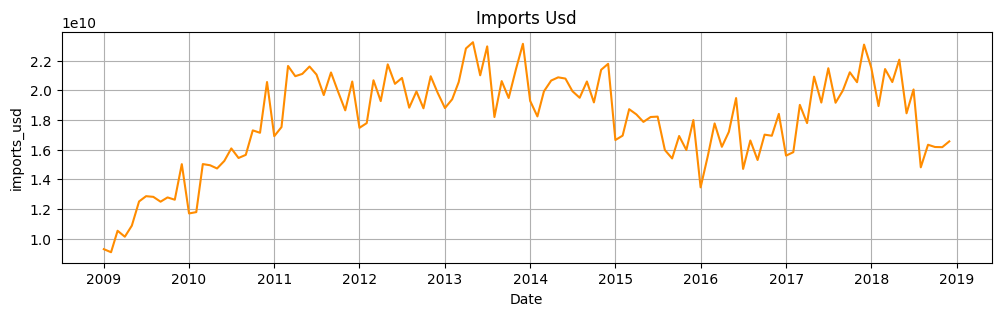

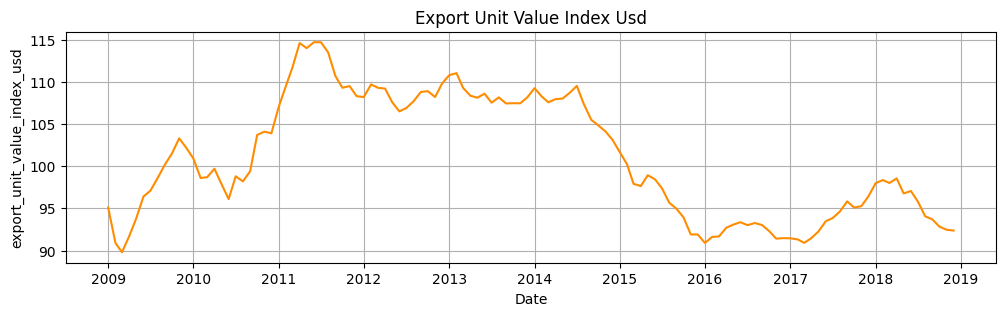

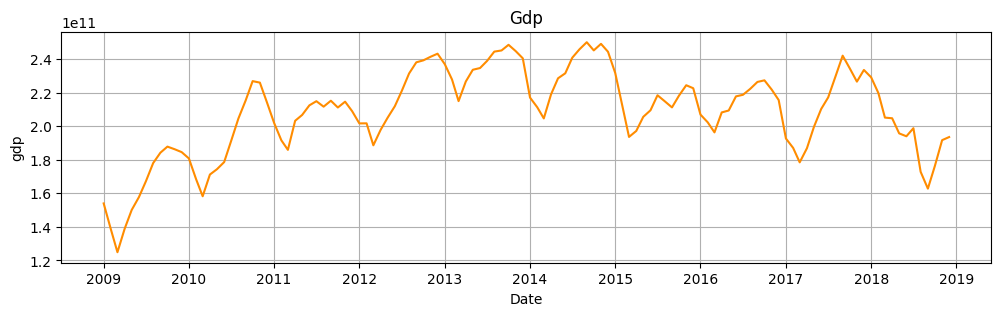

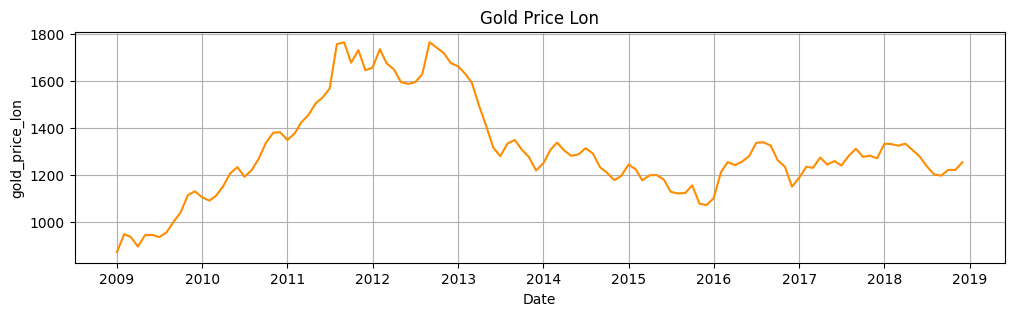

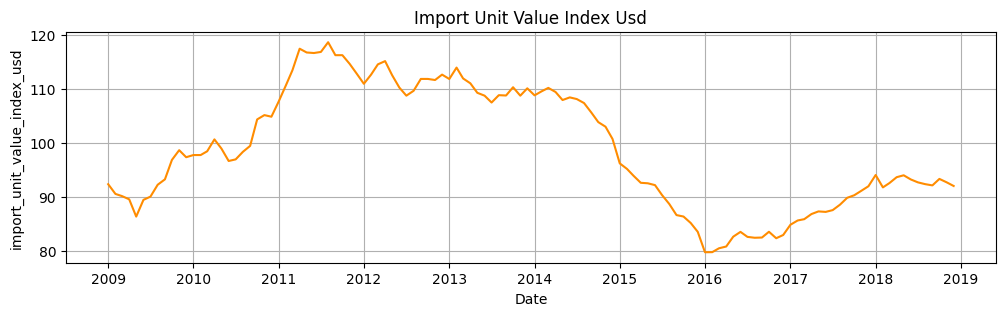

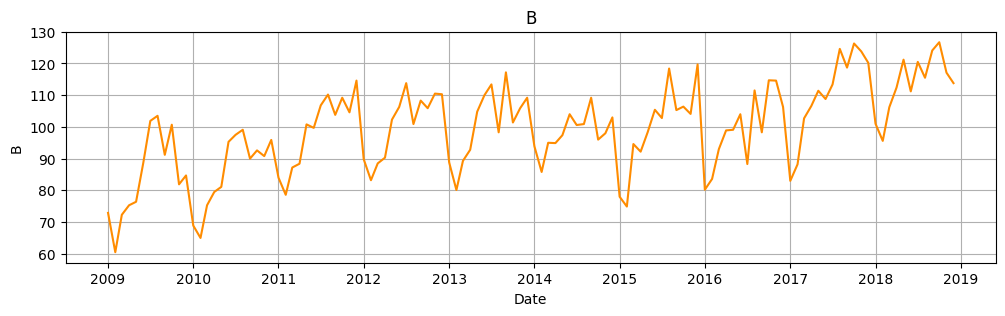

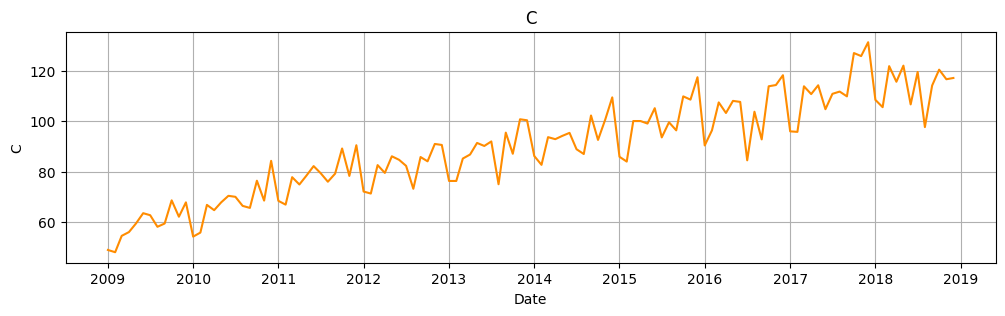

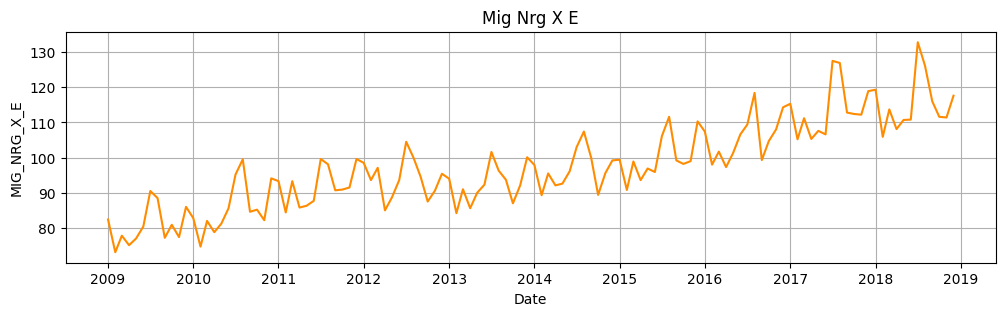

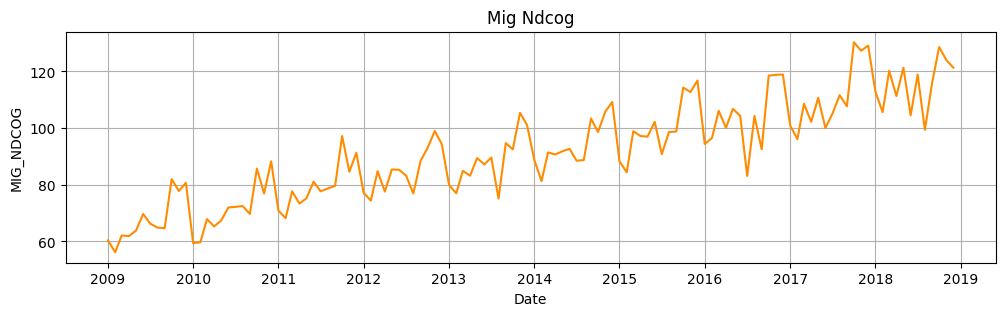

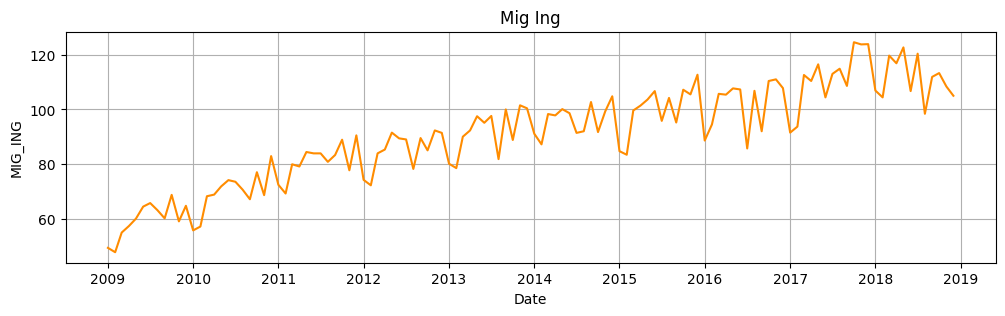

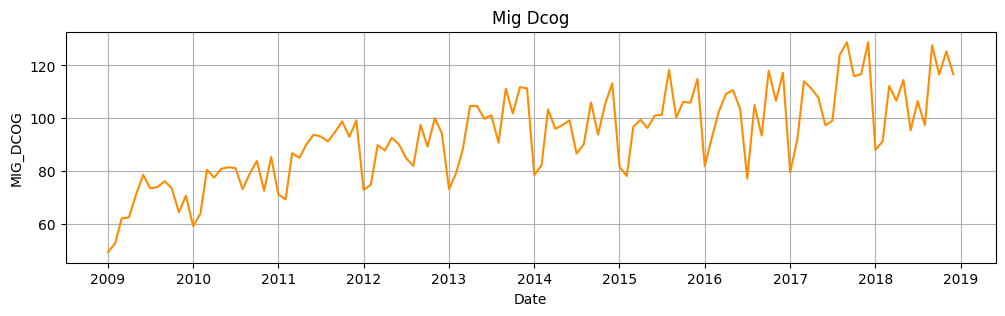

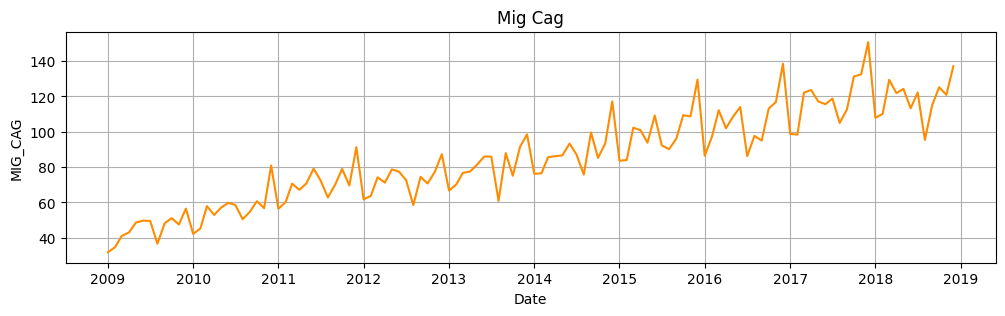

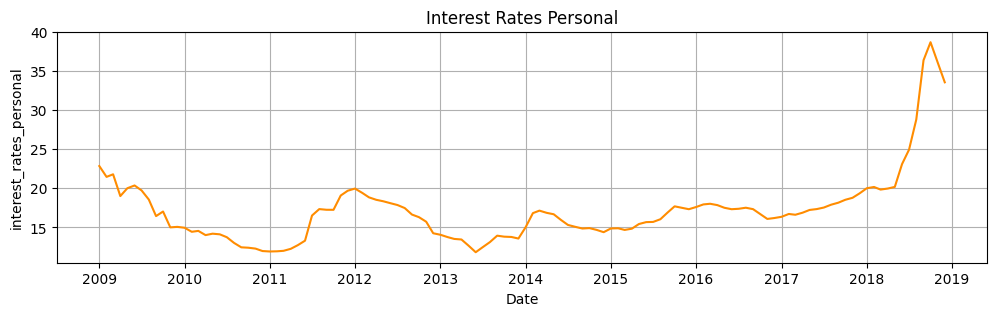

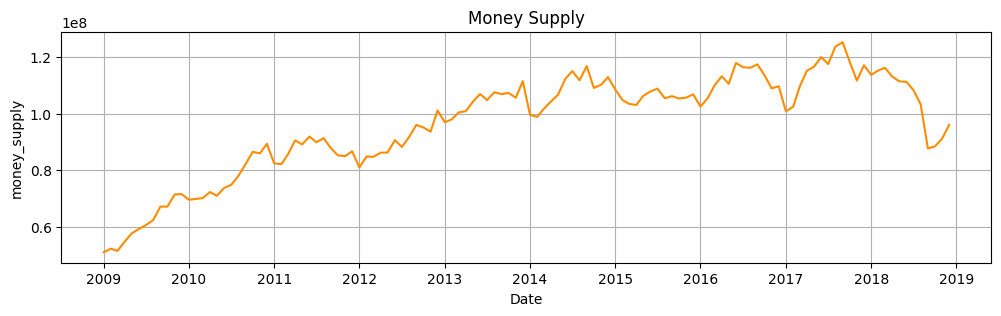

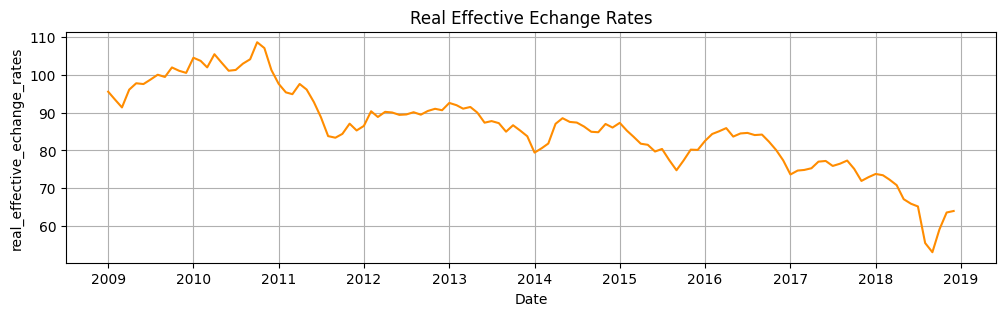

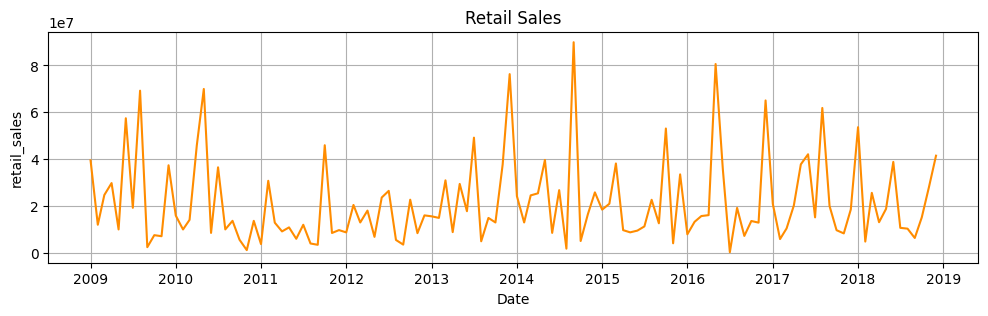

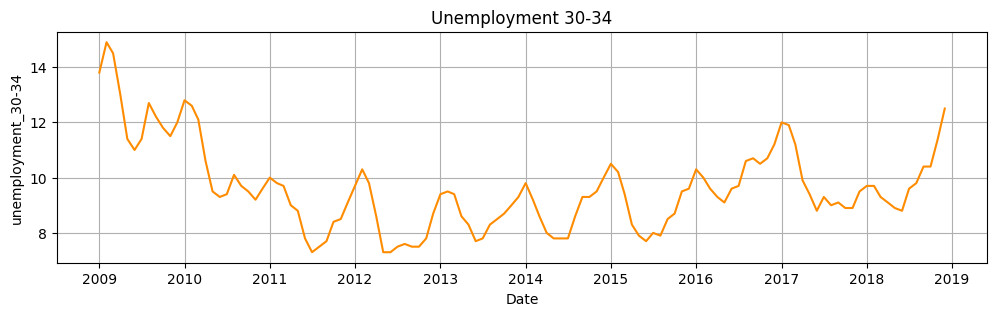

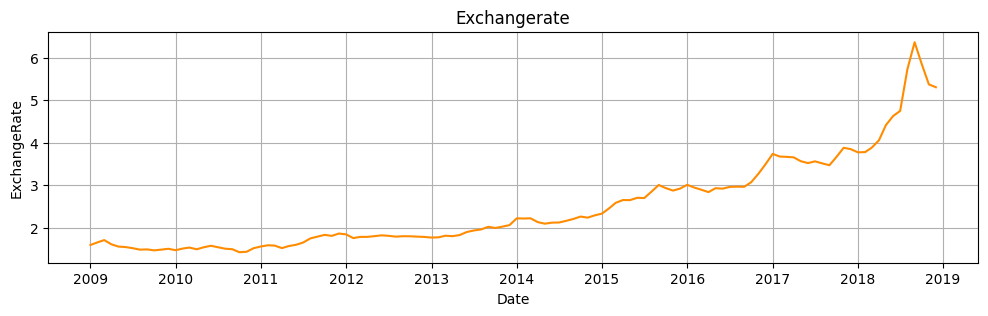

In [7]:
cols = df.columns[3:]

for col in cols:
    plot_timeseries(df, col)
    plt.show()

## Correlation matrix

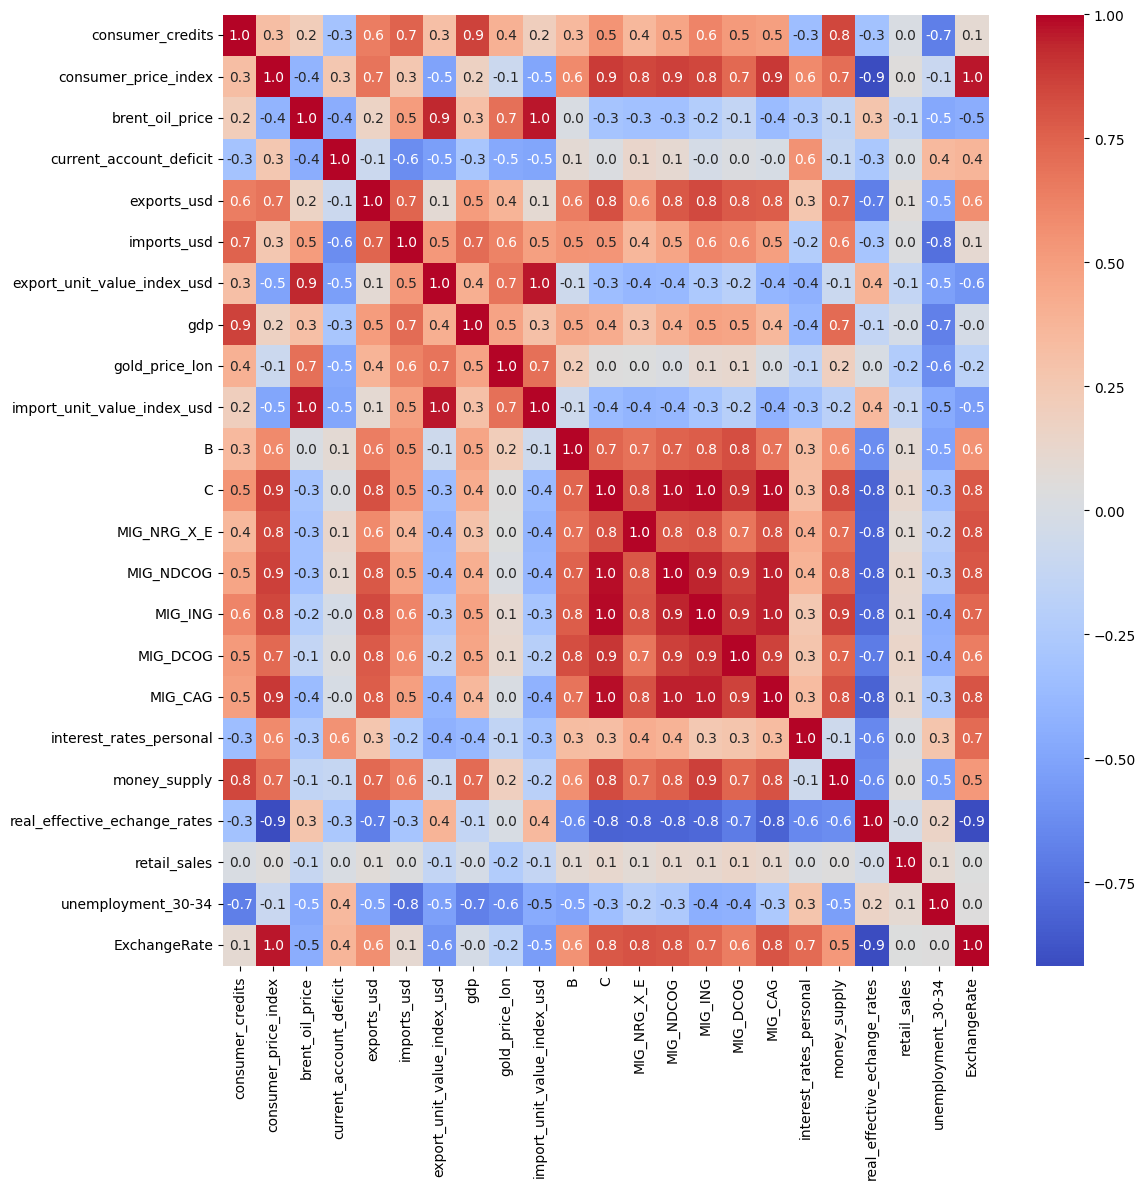

In [42]:
plt.figure(figsize=(12, 12), tight_layout=True)
sns.heatmap(df.iloc[:, 3:].corr(), cmap='coolwarm', annot=True, fmt='.1f')
plt.savefig('figures/feature_corr_matrix.pdf')
plt.show()

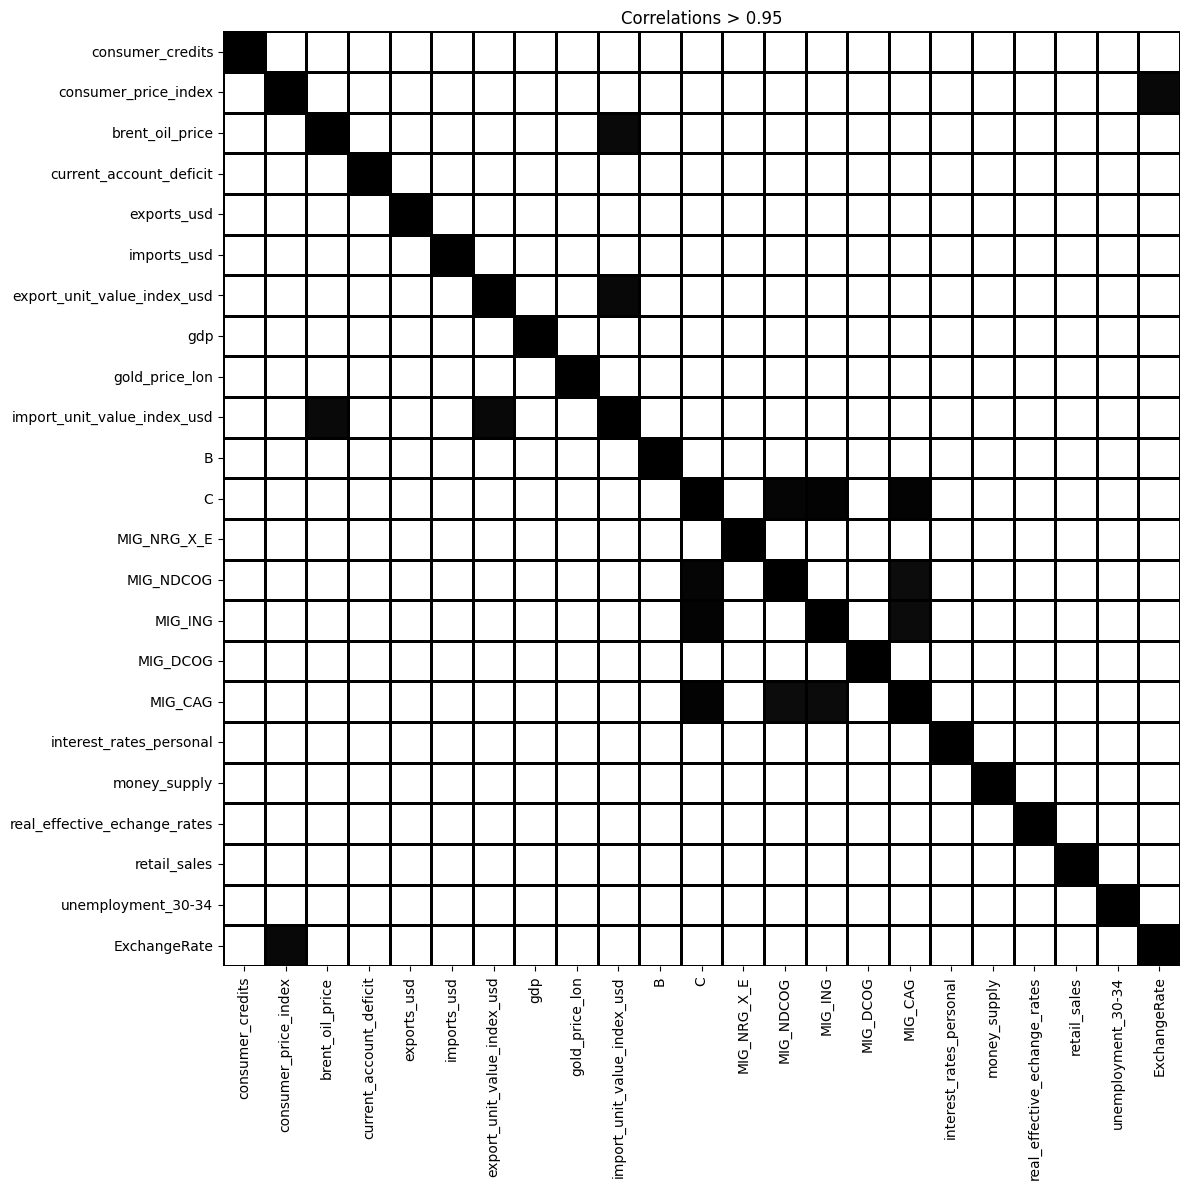

In [44]:
corr_matrix = df.iloc[:, 3:].corr()

cond_pos = (corr_matrix > 0.95)
cond_neg = (corr_matrix < -0.95)

corr_matrix = corr_matrix[cond_pos].fillna(0)

plt.figure(figsize=(12, 12), tight_layout=True)
sns.heatmap(corr_matrix, cmap='binary', linewidths=1, linecolor='black', cbar=False)
plt.title('Correlations > 0.95')
plt.savefig('figures/feature_positive_corr_matrix.pdf')
plt.show()

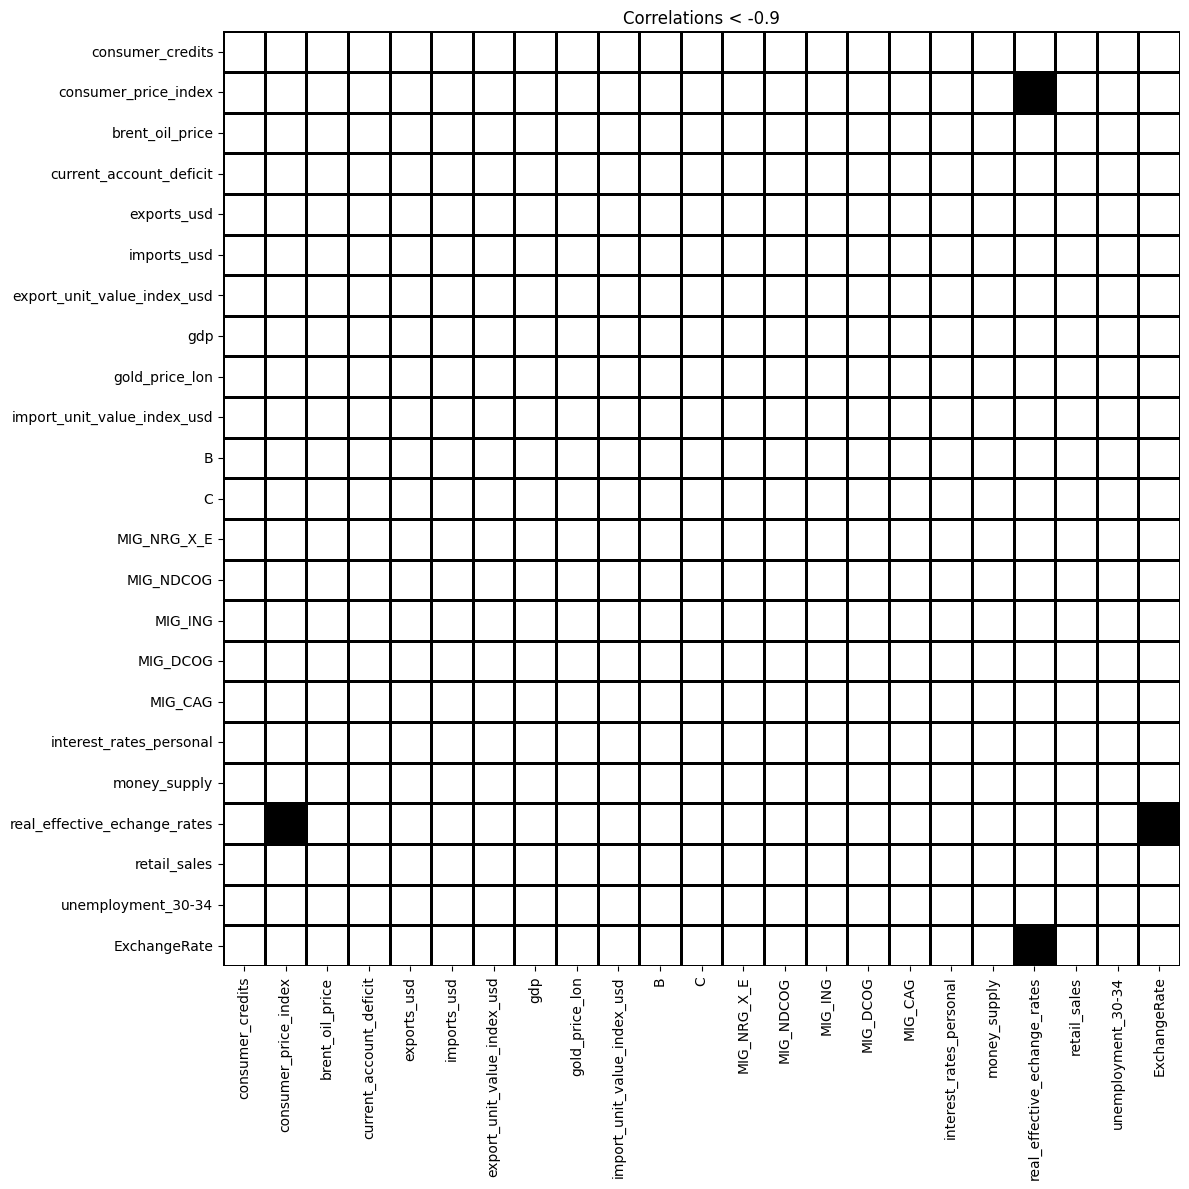

In [43]:
corr_matrix = df.iloc[:, 3:].corr()

cond_pos = (corr_matrix > 0.95)
cond_neg = (corr_matrix < -0.9)

corr_matrix = corr_matrix[cond_neg].fillna(0) * -1

plt.figure(figsize=(12, 12), tight_layout=True)
sns.heatmap(corr_matrix, cmap='binary', linewidths=1, linecolor='black', cbar=False)
plt.title('Correlations < -0.9')
plt.savefig('figures/feature_negative_corr_matrix.pdf')
plt.show()

Dropping the highly correlated features

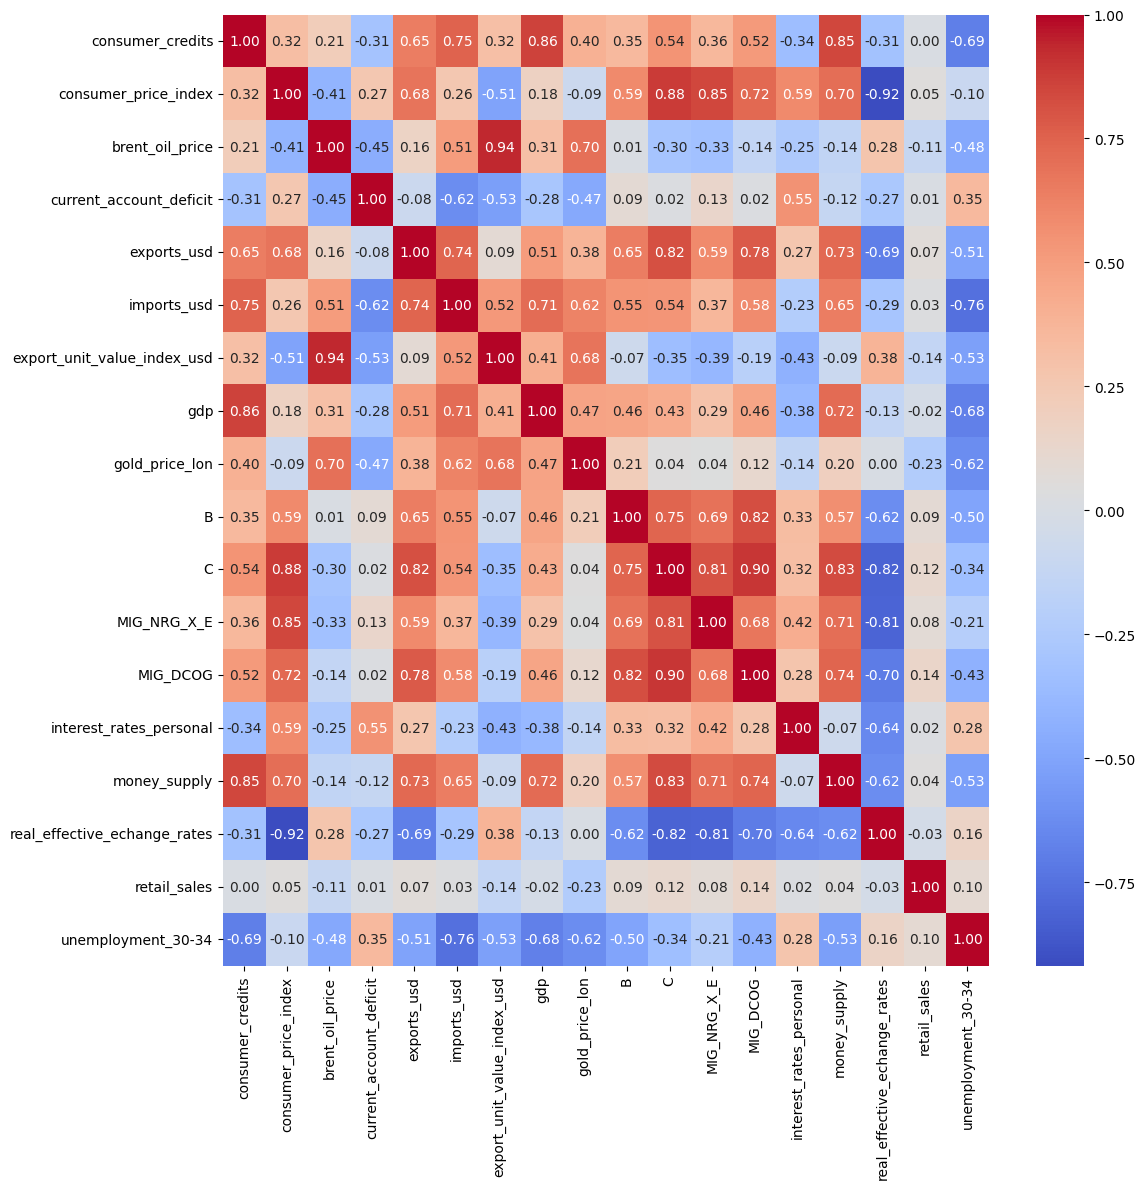

In [53]:
cols_to_drop = ['MIG_CAG', 'MIG_ING', 'MIG_NDCOG', 'ExchangeRate', 'import_unit_value_index_usd']

df1 = df.drop(columns=cols_to_drop)
plt.figure(figsize=(12, 12), tight_layout=True)
sns.heatmap(df1.iloc[:, 3:].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

### Variable distributions

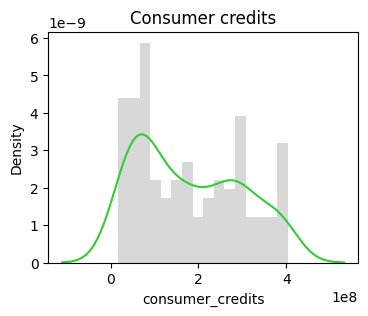

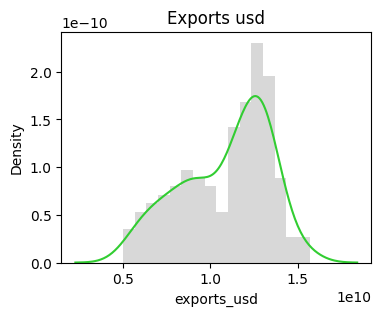

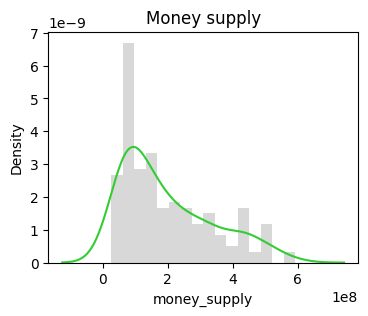

In [50]:
variables = ['consumer_credits', 'exports_usd', 'money_supply']
for variable in variables:
    fig, ax = plt.subplots(figsize=(4, 3))
    data = df[variable]
    sns.kdeplot(data, color='limegreen', ax=ax)
    ax.hist(data, density=True, bins=16, color='gray', alpha=0.3)
    ax.set_title(variable.replace('_', ' ').capitalize())
    plt.show()